#  Hanyu's version of Donghee's notebook

only change: consider all possible assignments and compare with sufficiently large K (in this case K = 10000)

In [13]:
## Initial setting
set.seed(15)
library(tidyverse)

#library(ggmap) #doesn't work for Hanyu's environment, but that's okay

library(dplyr) # Easier data manipulation
library(lfe) # For OLS

## Download data
df <- read.table("https://raw.github.com/DongheeJo/causal-analysis-netsi/master/data/HidingBox/data.txt",
    sep="\t",header=TRUE)

## Sort by gender
df <- df[order(df$gender,df$id),]
rownames(df) <- 1:nrow(df)

## In order to avoid dealing with missing data, let's plug in age = 6 for NA
# (of course in real research you can't do this)
df[8,'age']<-6

In [16]:
df

id,age,coat,gender,stray_cat,weight,treat,stress7,stress12,weight7,weight12
1,4,"red, white",0,0,5.14,1,2.222222,2.038462,-9.1439689,-11.4785992
8,6,"red, white",0,0,5.37,0,2.114286,2.222222,-14.1527002,-18.8081937
9,7,"red, white",0,0,6.27,1,2.121212,1.142857,-8.2934609,-9.7288676
10,3,"tabby, white",0,0,6.41,0,2.148148,2.361111,-8.7363495,-10.1404056
12,8,blue,0,0,5.41,0,2.833333,2.200000,-6.8391867,-7.7634011
15,3,"red, white",0,0,3.64,1,2.034483,2.111111,-6.3186813,-8.5164835
17,3,red,0,0,4.04,1,1.363636,1.576923,-6.9306931,-10.8910891
19,6,"tabby, white",0,0,5.43,0,2.409091,2.222222,-9.9447514,-11.0497238
21,6,"black, white",0,0,3.78,1,2.200000,2.090909,-4.2328042,-6.8783069
22,4,"white, tabby",0,0,4.57,1,2.160000,2.133333,1.0940919,1.5317287


**1) Let's first calculate Fisher's exact p-value**

In [17]:
df_grp <- df %>% add_count(gender) %>% group_by(gender, treat) %>%
    summarize(stress12 = mean(stress12), weight12 = mean(weight12), count = mean(n)) %>%
    arrange(desc(gender), desc(treat))

In [18]:
df_grp

gender,treat,stress12,weight12,count
1,1,1.932045,-5.028975,12
1,0,2.188712,-5.311478,12
0,1,1.848933,-7.660270,11
0,0,2.251111,-10.595823,11


In [19]:
T_stress <- abs(
    df_grp[1,'count']*(df_grp[1,'stress12']-df_grp[2,'stress12']) +
    df_grp[3,'count']*(df_grp[3,'stress12']-df_grp[4,'stress12'])
    ) %>% pull()

In [20]:
T_stress

[1] 7.503966

In [21]:
## Calculate (quite intiutive) test statistic of choice: weighted average of T_dif for males and females
# Some discussion can be found in Section 9.3 of Imbens and Rubin
df_grp <- df %>% add_count(gender) %>% group_by(gender, treat) %>%
    summarize(stress12 = mean(stress12), weight12 = mean(weight12), count = mean(n)) %>%
    arrange(desc(gender), desc(treat))
# df_grp[1,]: gender 1 treat 1
# df_grp[2,]: gender 1 treat 0
# df_grp[3,]: gender 0 treat 1
# df_grp[4,]: gender 0 treat 0
T_stress <- abs(
    df_grp[1,'count']*(df_grp[1,'stress12']-df_grp[2,'stress12']) +
    df_grp[3,'count']*(df_grp[3,'stress12']-df_grp[4,'stress12'])
    ) %>% pull()
T_weight <- abs(
    df_grp[1,'count']*(df_grp[1,'weight12']-df_grp[2,'weight12']) +
    df_grp[3,'count']*(df_grp[3,'weight12']-df_grp[4,'weight12'])
    ) %>% pull()

In [22]:
## For complete test, how many re-randomization do we need?
num_m <- table(df$gender)[["0"]][1]
num_f <- table(df$gender)[["1"]][1]
choose(num_f,6)*choose(num_m,6)

[1] 426888

In [30]:
##COMPLETE TEST --takes a little less than four hours
num_sim <- 426888
full_T <- as.data.frame(matrix(0, ncol = 2, nrow = num_sim))
names(full_T) <- c("T_stress","T_weight")

####
male_treatments <-combn(seq.int(num_m), 6, simplify = FALSE)
female_treatments <-combn(seq.int(num_m+1,num_f+num_m), 6, simplify = FALSE)
s<-0# shitty way of enumerating

####

#let's double for loop to get all potential combinations

for (male_t  in male_treatments) { #all male combinations
    
    for (female_t in female_treatments) { #all female combinations
        sim_df <- df
        sims <- data.frame("s" = 1:num_sim)

        #####
        a <-as.numeric(unlist(male_t)) 
        b <-as.numeric(unlist(female_t))
        ####
    
        sim_df$treat <- 0
        sim_df$treat[c(a,b)] <- 1

        sim_df_grp <- sim_df %>% add_count(gender) %>% group_by(gender, treat) %>%
            summarize(stress12 = mean(stress12), weight12 = mean(weight12), count = mean(n)) %>%
            arrange(desc(gender), desc(treat))
        full_T$T_stress[s] <- abs(
            sim_df_grp[1,'count']*(sim_df_grp[1,'stress12']-sim_df_grp[2,'stress12']) +
            sim_df_grp[3,'count']*(sim_df_grp[3,'stress12']-sim_df_grp[4,'stress12'])
            ) %>% pull()
        full_T$T_weight[s] <- abs(
            sim_df_grp[1,'count']*(sim_df_grp[1,'weight12']-sim_df_grp[2,'weight12']) +
            sim_df_grp[3,'count']*(sim_df_grp[3,'weight12']-sim_df_grp[4,'weight12'])
            ) %>% pull()

        s <- s+1 #enumerating
    
    }
}

In [31]:
full_T

T_stress,T_weight
1.9396697,97.13096
1.1396697,95.28516
2.4396697,92.36419
3.0063364,104.32844
0.6690259,97.21268
2.8285586,102.29149
1.4396697,94.10398
0.6396697,92.25818
1.9396697,89.33721
2.5063364,101.30146


[1] "P-value for stress:  0.00128605161072694"


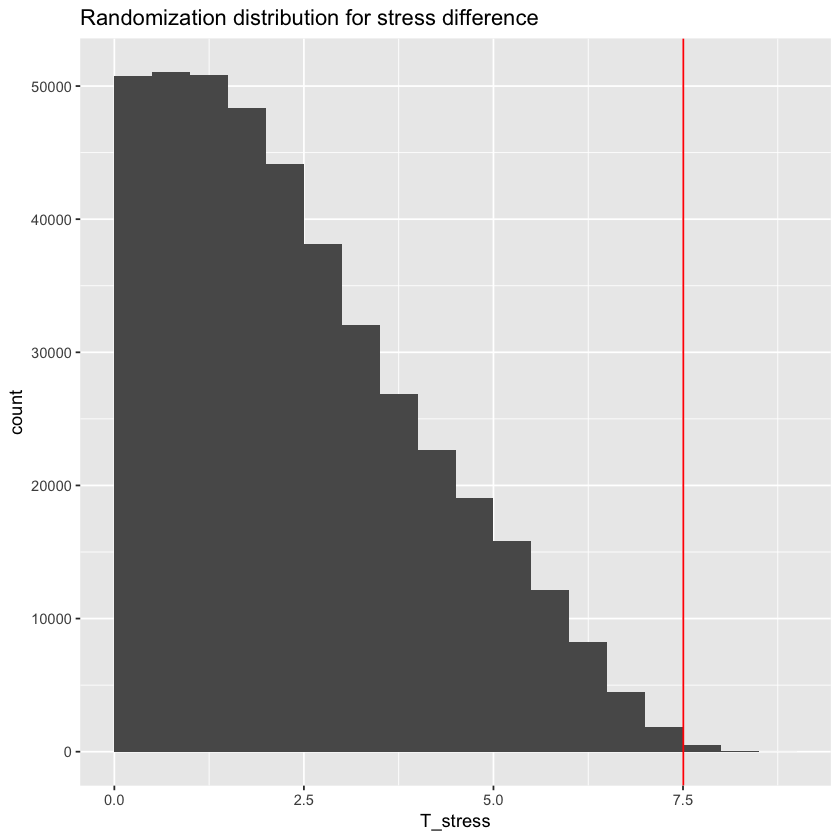

[1] "P-value for weight:  0.414471711549634"


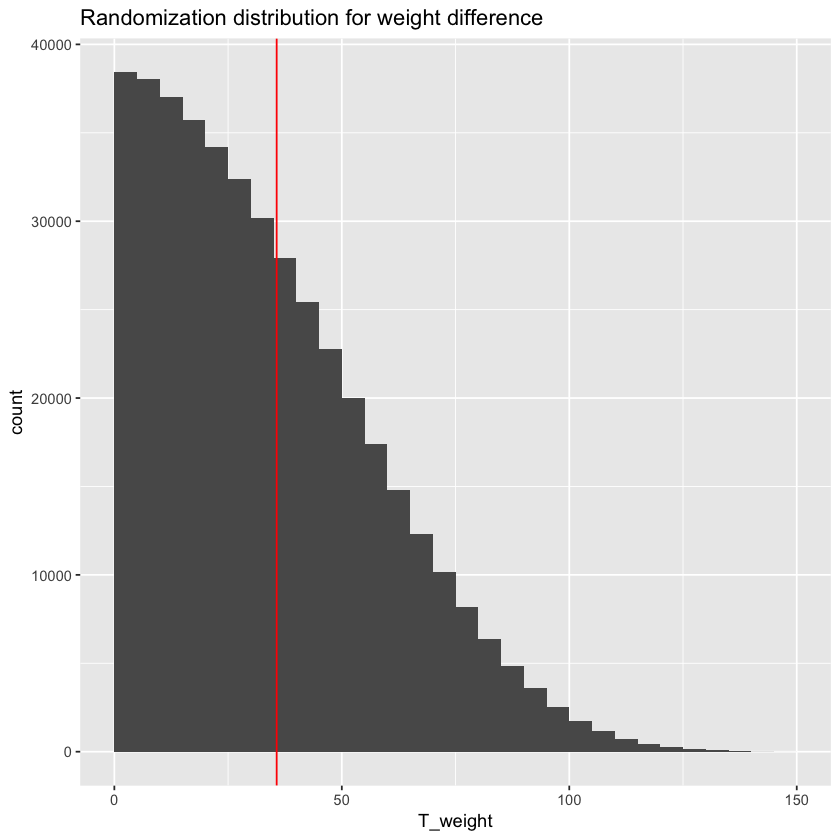

In [32]:
## DO COMPLETE TEST AND CALCULATE PVALUE

# 1. Stress
ggplot(data=full_T) +
    geom_histogram(mapping=aes(x=T_stress), boundary=0, binwidth=0.5) +
    geom_vline(xintercept=T_stress, color="red") +
    ggtitle("Randomization distribution for stress difference")
p_stress <- sum(full_T$T_stress >= T_stress)/num_sim
print(paste("P-value for stress: ",p_stress))

# 2. weight
ggplot(data=full_T) +
    geom_histogram(mapping=aes(x=T_weight), boundary=0, binwidth=5) +
    geom_vline(xintercept=T_weight, color="red") +
    ggtitle("Randomization distribution for weight difference")
p_weight <- sum(full_T$T_weight >= T_weight)/num_sim
print(paste("P-value for weight: ",p_weight))

In [33]:
## COMPARE TO SIMULATED TEST
num_sim = 10000
sim_T <- as.data.frame(matrix(0, ncol = 2, nrow = num_sim))
names(sim_T) <- c("T_stress","T_weight")

for (s in 1:num_sim) {
    sim_df <- df
    sims <- data.frame("s" = 1:num_sim)
    a <- sample(1:num_m, 6)
    b <- sample((num_m+1):(num_m+num_f),6)
    sim_df$treat <- 0
    sim_df$treat[c(a,b)] <- 1
    sim_df_grp <- sim_df %>% add_count(gender) %>% group_by(gender, treat) %>%
        summarize(stress12 = mean(stress12), weight12 = mean(weight12), count = mean(n)) %>%
        arrange(desc(gender), desc(treat))
    sim_T$T_stress[s] <- abs(
        sim_df_grp[1,'count']*(sim_df_grp[1,'stress12']-sim_df_grp[2,'stress12']) +
        sim_df_grp[3,'count']*(sim_df_grp[3,'stress12']-sim_df_grp[4,'stress12'])
        ) %>% pull()
    sim_T$T_weight[s] <- abs(
        sim_df_grp[1,'count']*(sim_df_grp[1,'weight12']-sim_df_grp[2,'weight12']) +
        sim_df_grp[3,'count']*(sim_df_grp[3,'weight12']-sim_df_grp[4,'weight12'])
        ) %>% pull()
}

[1] "P-value for stress:  9e-04"


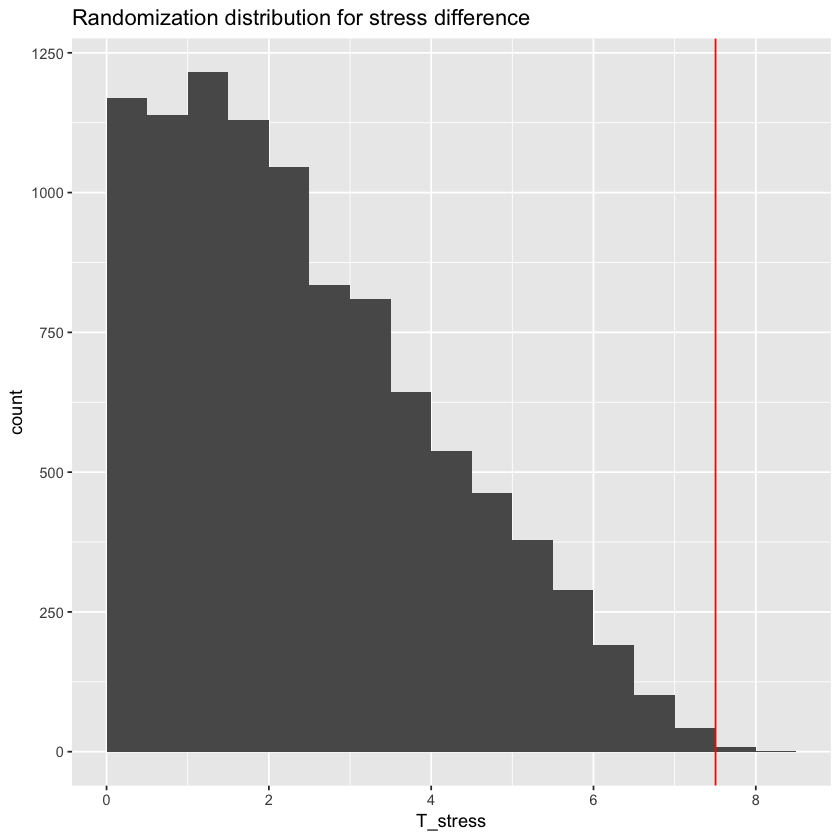

[1] "P-value for weight:  0.4162"


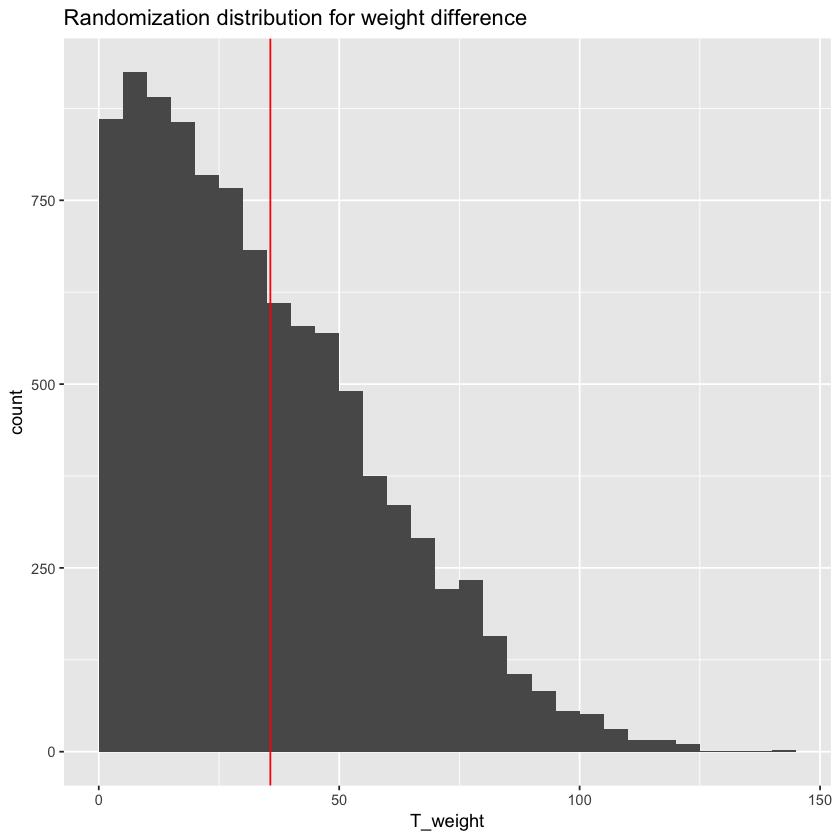

In [34]:
## Draw randomization distribution of our test statistics and calculate p_value.

# 1. Stress
ggplot(data=sim_T) +
    geom_histogram(mapping=aes(x=T_stress), boundary=0, binwidth=0.5) +
    geom_vline(xintercept=T_stress, color="red") +
    ggtitle("Randomization distribution for stress difference")
p_stress <- sum(sim_T$T_stress >= T_stress)/num_sim
print(paste("P-value for stress: ",p_stress))

# 2. weight
ggplot(data=sim_T) +
    geom_histogram(mapping=aes(x=T_weight), boundary=0, binwidth=5) +
    geom_vline(xintercept=T_weight, color="red") +
    ggtitle("Randomization distribution for weight difference")
p_weight <- sum(sim_T$T_weight >= T_weight)/num_sim
print(paste("P-value for weight: ",p_weight))

We can see that the test statistic distributions are close to identical.